In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scanpy
!pip install matplotlib==3.1.3

     |████████████████████████████████| 2.0 MB 13.5 MB/s 
     |████████████████████████████████| 88 kB 8.2 MB/s 
     |████████████████████████████████| 96 kB 6.1 MB/s 
     |████████████████████████████████| 11.2 MB 61.4 MB/s 
     |████████████████████████████████| 930 kB 55.0 MB/s 
     |████████████████████████████████| 1.1 MB 48.4 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=0c0b5135ceed6370c030521f4303e6b14b54b85a85e8838724ee221f365b5bba
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=1346974e25ca6c4b2a577fd9c170877b52bd399b565212b8d39daec6eaad61e0
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
  Created wheel for session-info: filename=session_info-1.0.0-py3-n

     |████████████████████████████████| 13.1 MB 24.1 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

Pancreas_adata = sc.read_text("/content/drive/My Drive/ML4FG 2022/Data/Pancreas Data/Processed/Pancreas_LogX_CellCycleRegressedOut.txt", delimiter = '\t', first_column_names=None)
sc.pp.scale(Pancreas_adata)
Pancreas_adata

AnnData object with n_obs × n_vars = 2209 × 26179
    var: 'mean', 'std'

In [4]:
PancreasMetadata = pd.read_csv("/content/drive/My Drive/ML4FG 2022/Data/Pancreas Data/Processed/PancreasMetadata.csv")
Pancreas_adata.obs['Cell Type'] = PancreasMetadata['Cell type'].values
Pancreas_adata.obs['Cell Type'].unique()

array(['γ', 'α', 'β', 'acinar', 'ε', 'unclassified exocrine', 'ductal',
       'δ', 'unclassified endocrine', 'endothelial', 'co-expression',
       'PSC', 'mast', 'MHC'], dtype=object)

In [5]:
PancreasCellID = []
for item in PancreasMetadata['Cell ID'].values:
  PancreasCellID.append(item)
Pancreas_adata.obs_names = PancreasCellID
Pancreas_adata.obs_names

Index(['HP1502401_H13', 'HP1502401_J14', 'HP1502401_B14', 'HP1502401_A14',
       'HP1502401_C14', 'HP1502401_G14', 'HP1502401_E14', 'HP1502401_L14',
       'HP1502401_M14', 'HP1502401_K14',
       ...
       'HP1526901T2D_M7', 'HP1526901T2D_N16', 'HP1526901T2D_C8',
       'HP1526901T2D_H2', 'HP1526901T2D_I16', 'HP1526901T2D_F7',
       'HP1525301T2D_K3', 'HP1525301T2D_J10', 'HP1526901T2D_N8',
       'HP1526901T2D_A8'],
      dtype='object', length=2209)

In [6]:
PancreasGenes = pd.read_csv("/content/drive/My Drive/ML4FG 2022/Data/Pancreas Data/Processed/Pancreas_Genelist.txt",header=None)
PancreasGenelist = []
for item in PancreasGenes.values.tolist():
  PancreasGenelist.append(item[0])
Pancreas_adata.var_names = PancreasGenelist
Pancreas_adata.var_names

Index(['SGIP1', 'AZIN2', 'CLIC4', 'AGBL4', 'NECAP2', 'SLC45A1', 'TGFBR3',
       'DBT', 'RFWD2', 'C1orf21',
       ...
       'KIR3DS1', 'KIR2DL5B', 'KIR2DS2', 'KIR2DS1', 'KIR2DL2', 'KIR2DL4',
       'KIR2DS3', 'KIR2DS2', 'BIVM-ERCC5', 'ERCC_30000:mix1_7500:mix2'],
      dtype='object', length=26179)

In [7]:
Pancreas_adata.obs['Cell Type'].unique()

array(['γ', 'α', 'β', 'acinar', 'ε', 'unclassified exocrine', 'ductal',
       'δ', 'unclassified endocrine', 'endothelial', 'co-expression',
       'PSC', 'mast', 'MHC'], dtype=object)

In [8]:
# Pancreas_adata.write(filename="/content/drive/My Drive/ML4FG 2022/Data/Pancreas Data/Processed/Pancreas_CellCycleRegressedOut_AnnData.h5ad")

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [10]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.linear = nn.Linear(input_dim, latent_dim)

    def forward(self, x):
        z = self.linear(x)
        return z

In [11]:
class Decoder(nn.Module):
    def __init__(self, output_dim, latent_dim):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(latent_dim, output_dim)

    def forward(self, z):
        x_hat = self.linear(z)
        return x_hat

In [12]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, output_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(output_dim, latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

In [13]:
softmax = nn.Softmax(dim=0)

def train(autoencoder, data, NumCellTypes, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    LossValues = []
    CellTypePredictions = []
    for cell in range(data.X.shape[0]):
      print('Cell: ' + str(cell+1))
      for epoch in range(epochs):
            x = torch.tensor(data.X[cell,:]).to(device)
            opt.zero_grad()
            x_hat, z = autoencoder(x)
            if epoch == epochs-1:
                CellTypePredictions.append(softmax(z).detach().numpy())
            loss = ((x - x_hat)**2).sum()
            LossValues.append(loss.detach().numpy())
            loss.backward()
            opt.step()
            print('Epoch: ' + str(epoch+1))
    return autoencoder, CellTypePredictions, LossValues

In [14]:
NumPancreasCellTypes = len(Pancreas_adata.obs['Cell Type'].unique())

autoencoder = Autoencoder(Pancreas_adata.shape[1], Pancreas_adata.shape[1], NumPancreasCellTypes)
autoencoder, PancreasCellProb, PancreasLoss = train(autoencoder, Pancreas_adata, NumPancreasCellTypes, epochs=50)
PancreasLoss = np.stack(PancreasLoss)

Streaming output truncated to the last 5000 lines.
Epoch: 49
Epoch: 50
Cell: 2112
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Cell: 2113
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch

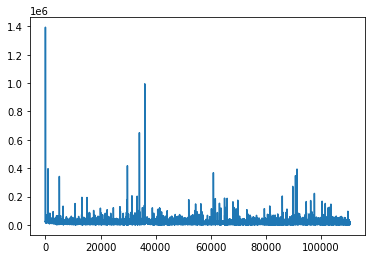

In [15]:
plt.plot(PancreasLoss)

In [16]:
PancreasLabels = []
for item in PancreasCellProb:
  PancreasLabels.append(str(np.where(item == max(item))[0][0]))

In [17]:
sc.tl.pca(Pancreas_adata, svd_solver='arpack', use_highly_variable=None)
sc.pp.neighbors(Pancreas_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(Pancreas_adata)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


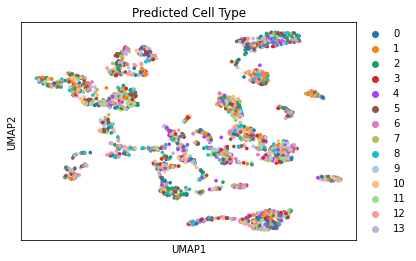

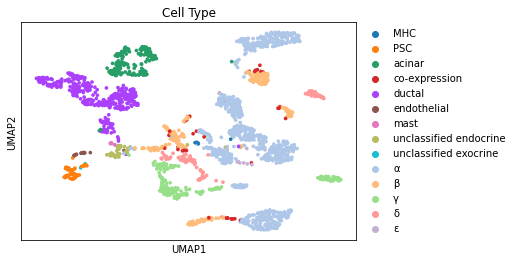

In [18]:
Pancreas_adata.obs['Predicted Cell Type'] = PancreasLabels

sc.pl.umap(Pancreas_adata, color=['Predicted Cell Type'])
sc.pl.umap(Pancreas_adata, color=['Cell Type'])

In [19]:
# Read and process GBM data 

GBM_adata = sc.read_text("/content/drive/My Drive/ML4FG 2022/Data/GBM Data/Processed/GBM_LogX.txt", delimiter = '\t', first_column_names=None)
GBM_adata = GBM_adata.T 

GBMCellCycleScores = pd.read_table("/content/drive/My Drive/ML4FG 2022/Data/GBM Data/Processed/GbmCellCycleScores.txt", delimiter = '\t')
GBM_adata.obs['score_S'] = GBMCellCycleScores['score_S'].values
GBM_adata.obs['score_G2M'] = GBMCellCycleScores['score_G2M'].values
sc.pp.regress_out(GBM_adata, ['score_S', 'score_G2M'])

# Scale (zero-center) data
sc.pp.scale(GBM_adata)

GBM_Metadata = pd.read_csv("/content/drive/My Drive/ML4FG 2022/Data/GBM Data/Processed/metadata2.csv")
GBM_adata.obs['Cell Type'] = GBM_Metadata['cell_assignment'].values

GBMGenes = pd.read_csv("/content/drive/My Drive/ML4FG 2022/Data/GBM Data/Processed/features2.tsv",header=None)
GBMGenelist = []
for item in GBMGenes.values.tolist():
  GBMGenelist.append(item[0])
GBM_adata.var_names = GBMGenelist
GBM_adata.var_names

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2MP1',
       'A4GALT', 'A4GNT', 'AA06',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=23686)

In [20]:
NumGBMCellTypes = len(Pancreas_adata.obs['Cell Type'].unique())
autoencoder_GBM = Autoencoder(GBM_adata.shape[1], GBM_adata.shape[1], NumGBMCellTypes)
autoencoder_GBM, GBM_CellProb, GBMLoss = train(autoencoder_GBM, GBM_adata, NumGBMCellTypes, epochs=50)
GBM_Loss = np.stack(GBMLoss)

Streaming output truncated to the last 5000 lines.
Epoch: 49
Epoch: 50
Cell: 7833
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Cell: 7834
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch

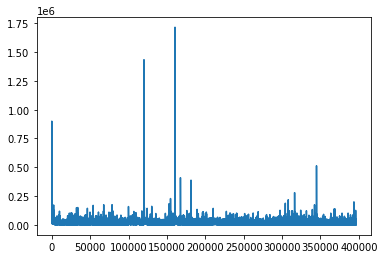

In [21]:
plt.plot(GBM_Loss)

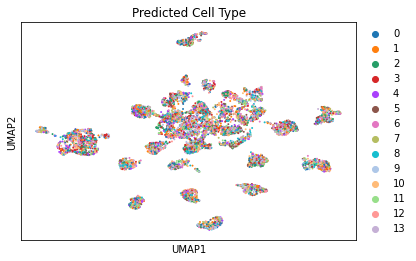

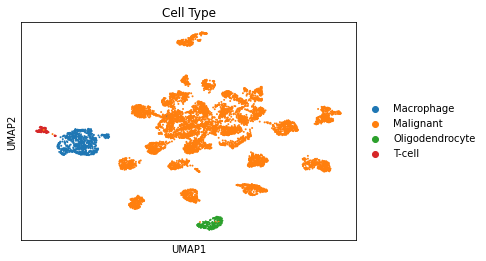

In [22]:
GBMLabels = []
for item in GBM_CellProb:
  GBMLabels.append(str(np.where(item == max(item))[0][0]))

GBM_adata.obs['Predicted Cell Type'] = GBMLabels

sc.tl.pca(GBM_adata, svd_solver='arpack')
sc.pp.neighbors(GBM_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(GBM_adata)

sc.pl.umap(GBM_adata, color=['Predicted Cell Type'])
sc.pl.umap(GBM_adata, color=['Cell Type'])